# Amazon Product Reviews Recommendation System Model Development

Julia A. Moffitt, PhD


The following is a project on Recommendation Systems. The Amazon product reviews dataset on electronic products was used to build and compare various recommendation system models. 

--------------
### Context: 
--------------

E-commerce websites like Amazon, Flipkart uses different recommendation models to provide personalized suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
### Objective:
----------------

Build a recommendation system to recommend products to customers based on their previous ratings for other products.

--------------
### Dataset:
--------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** Rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating (ignore this column for this exercise)

In [1]:
#You can use the following code to mount the drive if you use Google Colab for this project. It is not necessary to use Colab for this project.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#You must install the surprise package in Google Colab in order to use the same
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619437 sha256=f78ec08a3306317099f713c2344bf4764c5adb12f8913f65355d5e5fc851eac3
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


### Importing Libraries

In [3]:
import warnings #Used to ignore the warning given as output of the code.
warnings.filterwarnings('ignore')

import numpy as np # Basic libraries of python for numeric and dataframe computations.
import pandas as pd

import matplotlib.pyplot as plt #Basic library for data visualization.
import seaborn as sns #Slightly advanced library for data visualization

# from sklearn.metrics.pairwise import cosine_similarity #To compute the cosine similarity between two vectors.
from collections import defaultdict #A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error # A performance metrics in sklearn.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading data

In [5]:
#Import the data set
df = pd.read_csv('/content/drive/MyDrive/ADSP/Recommendation System/Amazon dataset/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

**As this dataset is very large and has 78,24,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Thus the dataset will be reduced by considering certain Logical assumptions.**

Here, We will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [6]:
# Get the column containing the users
users = df.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [7]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df = df.loc[~df.user_id.isin(remove_users)]

In [8]:
# Get the column containing the users
users = df.prod_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [9]:
# We want our item to have at least 5 ratings to be considred
RATINGS_CUTOFF = 5
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final = df.loc[~df.prod_id.isin(remove_users)]

In [10]:
# see a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


### Exploratory Data Analysis 

#### Shape of the data

In [11]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  65290
No of columns:  3


**Obervations:**

* The data contains 65,260 rows with 3 columns.

#### Data types

In [12]:
#Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Obervations:**
* The user ID and product ID are both object type data.  This means that we would not be able to perform mathematical operations on these and would need to treat as strings if printing etc.
* The rating is numerical with a decimal as indicated by the float64 data type.  This rating can have mathematical functions applied like sum, average etc.  
* We will be able to perform descriptive statistics only on the rating feature/variable.

#### Checking for missing values

In [13]:
# Check for missing values present and provide observations
df_final.isnull()

,user_id,prod_id,rating
1310,False,False,False
1322,False,False,False
1335,False,False,False
1451,False,False,False
1456,False,False,False
...,...,...,...
7824423,False,False,False
7824424,False,False,False
7824425,False,False,False
7824426,False,False,False


**Obervations:**

* There are no missing values in the data set.  
* This is helpful as we will not need to drop any entries or impute any values.

#### Summary Statistics

In [14]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Obervations:**
* The mean rating of all movies is 4.3, +/- 0.99 SD.
* This indicates that most ratings are likely distributed to higher values.  
* Since ratings are only limited between 1.0-5.0 it is impossible to have outliers unless there is an errant entry and since the max value is 5.0 there are no entries that need to be corrected.
* This range also limits the variability and thus keeps the SD low.
* The median value (50%) is 5.0 while the interquartile values are 25%=4.0 and 75% is 5.0
*  These values again indicate the data are skewed toward higher ratings than lower ratings.  
* If the data were normally distributed the median would be 3.5.

#### Checking the rating distribution

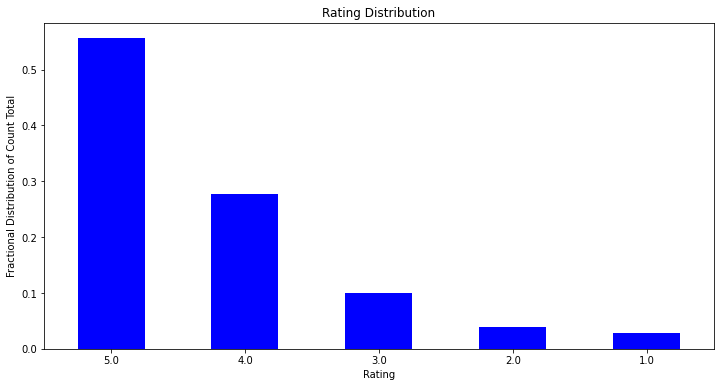

In [15]:
#Create the bar plot and provide observations

plt.figure(figsize = (12,6))
df_final['rating'].value_counts(1).plot(kind='bar', rot=0, color='blue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Fractional Distribution of Count Total')
plt.show()

**Observations:**
* The ratings distribution bar char shows that the data are indeed skewed right with a greater % of the total distribution toward higher ratings.
* ~80% of all data are a rating of 4.0 or 5.0 stars for the movies.
* Less than 10% of the rating distribution is held by low ratings of 1.0 or 2.0.
* This can help guide a threshold cutoff on ratings to filter only relevant ratings when building the model.

#### Checking the number of unique users and items in the dataset

In [16]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


- There are **1540 unique users and 5689 products** in the dataset

#### Users with most number of ratings

In [17]:
# Top 10 users based on rating
most_rated = df_final.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

- The highest number of **ratings by a user is 295** which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with.

### Data preparation  

In [18]:
#Check the number of unique USERS and PRODUCTS in the final data and provide observations

print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 65290
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  5689


**Observations:**
* Out of 65,290 total observations there are only 1540 unique users and 5689 unique products.  
* This means that users rated multiple products and there are also likely many products that were not rated by users.  
* If 1540 users rated 5689 products there would be 8,761,060 observations. 
* Thus only 65,290/8,761,060 = 7.4% of the matrix is filled.  
* The model will need to fill 92.6% of the matrix.  
* The data are considred **sparse**.

Now that data has been preprocessed the first recommendation system model will be built.

### Rank Based Recommendation System 

In [19]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [20]:
#Calculate the average rating for each product 
average_rating = df_final.groupby('prod_id').mean()['rating']

#Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [21]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    
    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]


#### Recommending top 5 products with 50 minimum interactions based on popularity

In [22]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

#### Recommending top 5 products with 100 minimum interactions based on popularity

In [23]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

The **top 5** products by using a popularity recommendation system has been built. Now, a recommendation system using collaborative filtering will be built

### Collaborative Filtering Based Recommendation System

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

#### Types of Collaborative Filtering

- Similarity/Neighborhood based
 * User User Similarity Based  
 * Item Item similarity based
- Model based

#### Building a baseline user user similarity based recommendation system

- Below we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library - `surprise` to build the remaining models, let's first import the necessary classes and functions from this library
- Please use the following code to `install the surprise` library. You don't need to run the following code if the surprise library is installed on your system.

**!pip install surprise**

In [24]:
# To compute the accuracy of models
from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing KFold cross-validation
from surprise.model_selection import KFold

#For implementing clustering-based recommendation system
from surprise import CoClustering

#### Before building the recommendation systems, the following basic terminologies will be used:

**Relevant item** - An item (product in this case) that is actually **rated higher than the threshold rating (here 3.5)** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item** - An item that's **predicted rating is higher than the threshold (here 3.5) is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN)** - It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider** which they would like to minimize.

**False Positive (FP)** - It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider** which they would also like to minimize.

**Recall** - It is the **fraction of actually relevant items that are recommended to the user** i.e. if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision** - It is the **fraction of recommended items that are relevant actually** i.e. if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are the two most used performance metrics used in the assessment of recommendation systems.**

### Precision@k and Recall@ k

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-Score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### Some useful functions

- Below function takes the **recommendation model** as input and gives the **precision@k and recall@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.

In [25]:
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    #Making predictions on the test data
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    #Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    #Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)
    
    accuracy.rmse(predictions)
    print('Precision: ', precision) #Command to print the overall precision
    print('Recall: ', recall) #Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) # Formula to compute the F-1 score.

Below we are loading the **`rating` dataset**, which is a **pandas dataframe**, into a **different format called `surprise.dataset.DatasetAutoFolds`** which is required by this library. To do this we will be **using the classes `Reader` and `Dataset`**

In [26]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [27]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

- Now we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.
- **KNNBasic** is an algorithm that is also **associated with the surprise package**, it is used to find the **desired similar items among a given set of items**.

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 is taken for the recommended and relevant ratings**. 
- In the **present case precision and recall both need to be optimized as the service provider would like to minimize both the losses discussed** above. Hence, the correct performance measure is the **F_1 score**. 

### Question: Build the user-user similarity-based recommendation system 
- Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1 
- Fit the model on the training data 
- Use the precision_recall_at_k function to calculate the metrics on the test data 

In [28]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': True}

#Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Observations:**
* The RMSE on this model was 1.0012.  This is the error of using the model to estimate the recommendations.  This value could be a little lower, but it is a decent fit for the first model.
* This model shows that 86% of all recommended products were releant to the user as Precision = 0.855, however this could be better.
* Similarly Recall = 0.856 indicating that 8% of all relelevant products are recommended to the user with this mode. 
* The overall accuracy of the model, indicated by the F1 score was 0.856.  
* Overall the model performs fairly well to recommend electronic products appropriately but it could be improved.

 **Predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466'.

In [29]:
#predicting rating for a sample user with an interacted product.
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

A3LDPF5FMB782Z, 1400501466

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [30]:
df_final[df_final.prod_id=="1400501466"].user_id.unique()

array(['A3LDPF5FMB782Z', 'A1A5KUIIIHFF4U', 'A2XIOXRRYX0KZY',
       'AW3LX47IHPFRL', 'A1E3OB6QMBKRYZ', 'A19N3S7CBSU6O7'], dtype=object)

* It can be observed from the **above list that user "A34BZM6S9L7QI4" has not seen a product with productId "1400501466"**.

Below we are **predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not seen yet i.e. `prod_id=1400501466`** 

In [31]:
#predicting rating for a sample user with a non interacted product.
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Improving similarity-based recommendation system by tuning its hyper-parameters

Below we will be tuning hyperparameters for the `KNNBasic` algorithms. Let's try to understand some of the hyperparameters of KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [32]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting the data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9719067399757174
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, the **optimal values for each of those hyperparameters** as shown above can be determined.

 **The final model by using tuned values of the hyperparameters** which we received by using **grid search cross-validation** will be built.

In [64]:
# using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, random_state=1, verbose=False)

# training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10.
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


- It can be observed from above that after tuning hyperparameters, **F_1 score of the tuned model is slightly better than the baseline model**. Along with this **the RMSE of the model has gone down as compared to the model before hyperparameter tuning**. Hence, we can say that the model performance has improved slightly after hyperparameter tuning.

### The following will be explored: 
- Predict rating for the user with `userId`="A3LDPF5FMB782Z", and `prod_id`= 1400501466 using the optimized model 
- Predict rating for the same userId="A34BZM6S9L7QI4" but for a product which this user has not interacted before i.e. prod_id = 1400501466, by using the optimized model 
- Compare the output with the output from the baseline model 

In [34]:
#Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466.
sim_user_user.predict('A3LDPF5FMB782Z', 1400501466, r_ui=4, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=4, est=4.292024046561495, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [65]:
#Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations:**
* The optimized model estimated a rating of 4.29, while the actual rating was 4.0, thus over-estimated for a user with a known interaction rating.
* The optimized model estimated a rating for a different user at 4.29 for an item that user had not interacted with.  
* This optimized model is close but may be slightly over-estimating the ratings.

In [36]:
df_final

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0
...,...,...,...
7824423,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
7824424,A1G650TTTHEAL5,B00LGQ6HL8,5.0
7824425,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0


## Identifying similar users to a given user (nearest neighbors)

Finding **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric are obtained.

In [66]:
sim_user_user_optimized.get_neighbors(0,5) #Here 0 is the inner id of the above user.

[6, 7, 17, 26, 32]

#### Implementing the recommendation algorithm based on optimized KNNBasic model

Implementing a function where the input parameters are - 

- data: a **rating** dataset
- user_id: a user id **against which we want the recommendations**
- top_n: the **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [38]:
def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='prod_id', values='rating')
    
    # extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

#### Predicted top 5 products for userId="A3LDPF5FMB782Z" with similarity based recommendation system

In [39]:
#Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [40]:
#Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### Correcting the Ratings and Ranking the above products

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**. Along with the rating the **number of users who have seen that product** also becomes important to consider. Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly higher the **"rating_count" of a product more it is liked by users**. To interpret the above concept, a **product rated 4 with rating_count 3 is less liked in comparison to a product rated 3 with a rating count of 50**. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [41]:
def ranking_products(recommendations, final_rating):
  # sort the products based on ratings count
  ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  # merge with the recommended products to get predicted ratings
  ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings']), on='prod_id', how='inner')

  # rank the products based on corrected ratings
  ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

  # sort the products based on corrected ratings
  ranked_products = ranked_products.sort_values('corrected_ratings', ascending=False)
  
  return ranked_products

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some products with ratings 5 and **we can't have a rating more than 5 for a product**.

In [42]:
#Applying the ranking products function and sorting it based on corrected ratings. 
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00834SJSK,101,5,4.900496
1,B001TH7GUU,78,5,4.886772
2,B000BQ7GW8,54,5,4.863917
3,B000067RT6,41,5,4.843826
4,B005ES0YYA,26,5,4.803884


### Item Item Similarity-based collaborative filtering recommendation systems 

* Above we have seen **similarity-based collaborative filtering** where similarity has seen **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [43]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': False}

#KNN algorithm is used to find desired similar items.
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10.
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


- The baseline model is giving a good F_1 score of ~84%. We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

 **Predict a rating for a user with `userId=A3LDPF5FMB782Z` and `prod_Id=1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [44]:
#predicting rating for a sample user with an interacted product.
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

 **Predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not interacted yet i.e. `prod_id=1400501466`** 

In [45]:
#predicting rating for a sample user with a non interacted product.
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Improving similarity-based recommendation system by tuning its hyper-parameters

**Tuning hyperparameters for the `KNNBasic` algorithms**. The following **hyperparameters** of the KNNBasic algorithm will be considered:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

### Hyperparameter tuning the item-item similarity-based model 
- Use the following values for the param_grid and tune the model 
  - 'k':[10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure 
- Print the best score and best parameters 

In [46]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.9748995290353791
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Obtaining the **optimal values for each of those hyperparameters as shown above**

Build the **final model** by using **tuned values of the hyperparameters** received by using grid search cross-validation

### Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model and compare the performance of the optimized model with the baseline model. 

In [47]:
# using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=6, random_state=1, verbose=False)

# training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score@k and RMSE
precision_recall_at_k(sim_item_item_optimized)


RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Observations:**
* The RMSE on this optimized model for the training set was lower than the previous model, indicating a reduced error/loss in the estimation and a better fit.
* The precision was 84%, thus the optimized model predicted 84% of recommended items that are relevant.
* The recall was higher than the previous model indicating that 88% of relevant items were recommended to the user.  
* The F1 score was similar at 0.859, indicating an overall performace similar to the previous model after hypertuning parameters.

Predict **rating for an user with `userId=A3LDPF5FMB782Z` and for `prod_id=1400501466`** with the **optimized model** as shown below

In [48]:
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

**Predicting rating** for the same **`userId=A34BZM6S9L7QI4`** but for a product which this user **has not interacted before** i.e. `prod_id==1400501466`, by using the optimized model as shown below - 

In [49]:
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Identifying similar users to a given user (nearest neighbors)

Finding **similar users** to a given user or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding 5 most similar users to the user with internal id 0 based on the `msd` distance metric

In [50]:
sim_item_item_optimized.get_neighbors(0, k=5)

[29, 53, 67, 106, 151]

#### Predicted top 5 products for userId="A1A5KUIIIHFF4U" with similarity based recommendation system

In [51]:
#Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [52]:
#Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


In [53]:
#Applying the ranking products function and sorting it based on corrected ratings. 
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,9983891212,8,4.292024,3.938471
1,B00000J1V5,7,4.292024,3.914060
2,1400532655,6,4.292024,3.883776
3,1400599997,5,4.292024,3.844810
4,B00000DM9W,5,4.292024,3.844810


* Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

#### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

### Building the matrix factorization recommendation system (using random_state=1)

In [54]:
# using SVD matrix factorization
svd = SVD(random_state=1)

# training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score@k, and RMSE
precision_recall_at_k(svd)


RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


- Predict the rating for a user with `userId="A3LDPF5FMB782Z"` and `prod_id="1400501466` as shown below
- Here the user has already rated the product.

In [55]:
#Making prediction.
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

Below we are predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not interacted before i.e. `productId=1400501466`, as shown below - 

In [56]:
#Making prediction. 
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

#### Improving matrix factorization based recommendation system by tuning its hyper-parameters

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [57]:
# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting data
gs_.fit(data)

# best RMSE score
print(gs_.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8993607767885635
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters as shown above

**Build the final model** by using **tuned values** of the hyperparameters which were obtained using grid search cross-validation

### Fit the SVD model using the hyperparameters from GridSearchCV (use random_state=1) and compare the output with the baseline model

In [58]:
# Build the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score@k, and RMSE
precision_recall_at_k(svd_optimized)


RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Observations:**
* The SVD model using tuned hyperparameters had a good fit with a relatively low RMSE = 0.8808, indicating a low error from the prediction to actual fit in the training set.
* Precision indicated 86% of recommended items were relevant, while the SVD model performs such that 88% of relevant items are recommended to the users.  
* The overall performace as indicated by the F1 score was 0.866.
* As compared to the baseline model (Colabarative Filtering with KNN) the SVD model with hyperparameters performs better overall with lower error in the prediction.  
* However, there were only minimal improvements with hyprtuning as compared to the SVD model that was not tuned.

### Exploration of the following relevant items: 
- Using the optimized svd model, predict rating for the user with `userId`="A3LDPF5FMB782Z", and `prod_id`= 1400501466 
- Predict rating for the same userId="A34BZM6S9L7QI4" but for a product which this user has not interacted before i.e. prod_id = 1400501466, by using the optimized model 
- Compare the output with the output from the baseline model 

In [59]:
#Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466.
svd_optimized.predict("A3LDPF5FMB782Z", 1400501466 , r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.22   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.218413807108248, details={'was_impossible': False})

In [60]:
#Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.49   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.493954027283759, details={'was_impossible': False})

**Observations:**
* The optimized SVD model closely predicted the rating as the estimate was 4.22 while the actual was 5.00.  This indicates the SVD model slightly under-estimtes the rating.
* For a user that has not interacted with a product a rating of 4.49 was estimted.  
* These estimates are much better and closer using the optimized SVD model as compared to the SVD model that was not tuned for hyperparameters for an individual user.

In [61]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [62]:
#Get top 5 recommendations for user_id A2XIOXRRYX0KZY using "svd_optimized" algorithm.
svd_recommendations = get_recommendations(df_final, "A2XIOXRRYX0KZY", 5, svd_optimized)

In [63]:
#Ranking products based on above recommendations
ranking_products(svd_recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00IVPU6AA,14,4.851976,4.584715
2,B000JV9LUK,10,4.888310,4.572082
1,B0010Y414Q,11,4.860932,4.559421
3,B00AR95ESC,9,4.858811,4.525478
4,B005PQTYHE,7,4.842736,4.464772


### Final Conclusions 

**Conclusions:**
* In developing a model to accurately recommend Amazon electronic products to users several model approaches were used and explored.
* Overall, the data are sparse but there are ratings and information so it is not a cold-start problem.  
* Rank-based was used but is not the best method as this is not a cold-start issue and data do exist for users and item ratings.
* Collaborative Filtering resulted in good overall model performance and hyperparameter tuning slightly improved the overall performance and reduced the error of the estimation.
* This was true for both user-user and item-item collaborative filtering.
* Single value decomposition performed the best overall with a low RMSE=0.8882 and good precision, recall and overall performance.  
* Hyperparameter tuning, resulted in only minimal improvements in the SVD model.
* It is recommended that use of the SVD model is the best of the models evaluated to recommend electronic products to users on Amazon using these sparse data.
* Use of tuning with hyperparameters didn't always improve model performance in a significant way.  
* The SVD model could be deployed to elicit accurate recommendations of electronic products to users on Amazon.   